In [18]:
import pandas as pd
import sys
from sklearn.model_selection import train_test_split
from google.colab import drive

#Mount Drive, set path
drive.mount('/content/drive')
drive_root = '/content/drive/MyDrive'

if drive_root not in sys.path:
    sys.path.append(drive_root)

#Importing modules
from src.analysis.classifier import ModelClassifier
from src.analysis.explainability import shap_explain
from src.analysis.robustness import test_robustness

#Load data
data_path = f"{drive_root}/aesthetics_project/merged_features.csv"
df = pd.read_csv(data_path)
print(f"Data loaded: {df.shape[0]} documents.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded: 320 documents.


# **Dialogue**

In [19]:
# Separate features from metadata
exclude_cols = ['doc_id', 'model', 'genre', 'prompt', 'text']
feature_columns = [col for col in df.columns if col not in exclude_cols]

#genre for robustness test
robustness_genre = 'dialogue'

# Split dataset:
#Standard texts (to Train/Test) and Robustness texts (Holdout)
df_standard = df[df['genre'] != robustness_genre]
df_robust = df[df['genre'] == robustness_genre]

#standard training/testing sets (narration, argumentation, description, aka all genres except the Holdout)
X = df_standard[feature_columns]
y = df_standard['model']

# 80/20 split for standard evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} documents")
print(f"Standard Testing set size: {X_test.shape[0]} documents")
print(f"Robustness set size (Only {robustness_genre}): {df_robust.shape[0]} documents")

Training set size: 192 documents
Standard Testing set size: 48 documents
Robustness set size (Only dialogue): 80 documents


Evaluating on standard test set...
--- Classification Report ---
              precision    recall  f1-score   support

      Claude       1.00      1.00      1.00        12
         GPT       1.00      1.00      1.00        12
       LLaMA       1.00      1.00      1.00        12
     Mistral       1.00      1.00      1.00        12

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



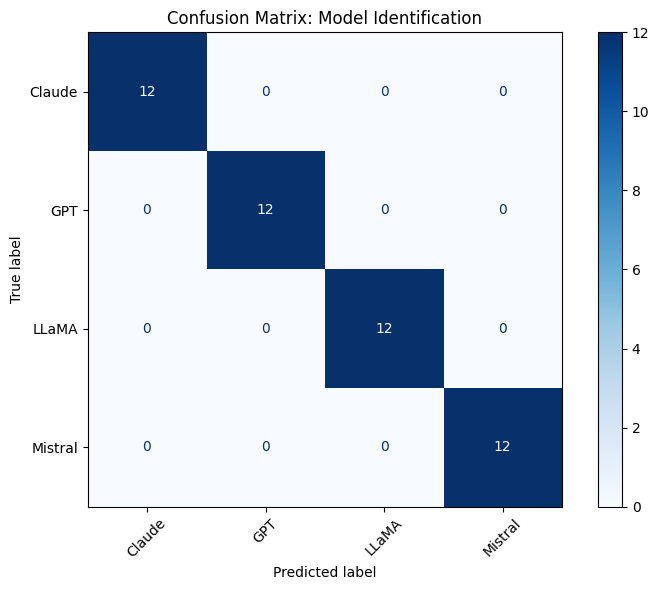

/content/drive/MyDrive/src/analysis/classifier.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


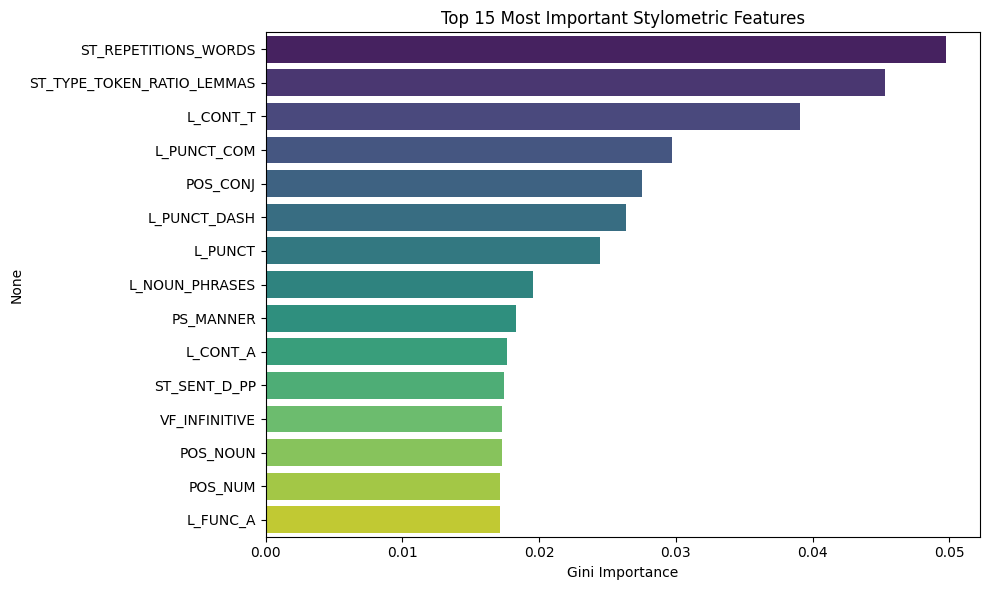

In [20]:
#Initialization & training
classifier = ModelClassifier(n_estimators=200)
classifier.train(X_train, y_train, feature_columns)

# Evaluation on standard test set
print("Evaluating on standard test set...")
predictions = classifier.evaluate(X_test, y_test)

# Plot standard Feature Importances
classifier.plot_feature_importance(top_k=15)

Calculating SHAP values...


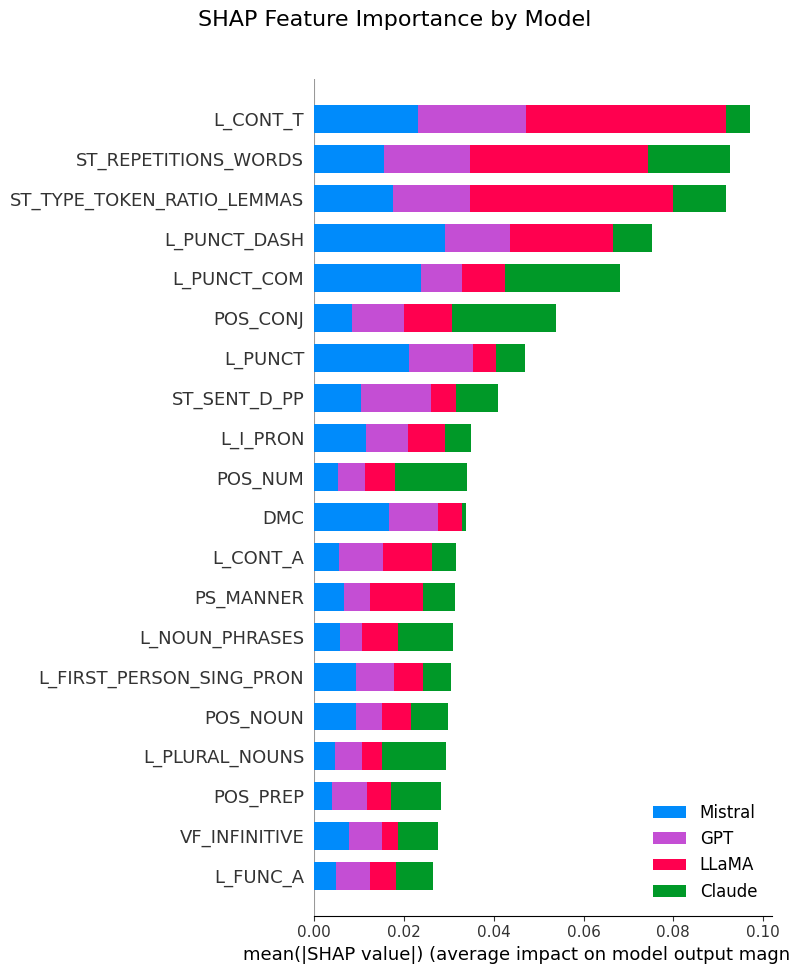

In [21]:
#Explainabilty: Using shap to understand what features helped more in making that prediction
#NOTE: the bottom axis title is cut off. What it says is :"mean(|SHAP value|) (average impact on model output magnitude)""
shap_explain(classifier, X, feature_columns)

--- Testing Robustness ---
Evaluating how well the classifier identifies models on the unseen 'dialogue' genre:
--- Robustness Test: Style-Modified Prompts ---
              precision    recall  f1-score   support

      Claude       0.27      1.00      0.43        20
         GPT       0.00      0.00      0.00        20
       LLaMA       1.00      0.05      0.10        20
     Mistral       0.67      0.20      0.31        20

    accuracy                           0.31        80
   macro avg       0.49      0.31      0.21        80
weighted avg       0.49      0.31      0.21        80



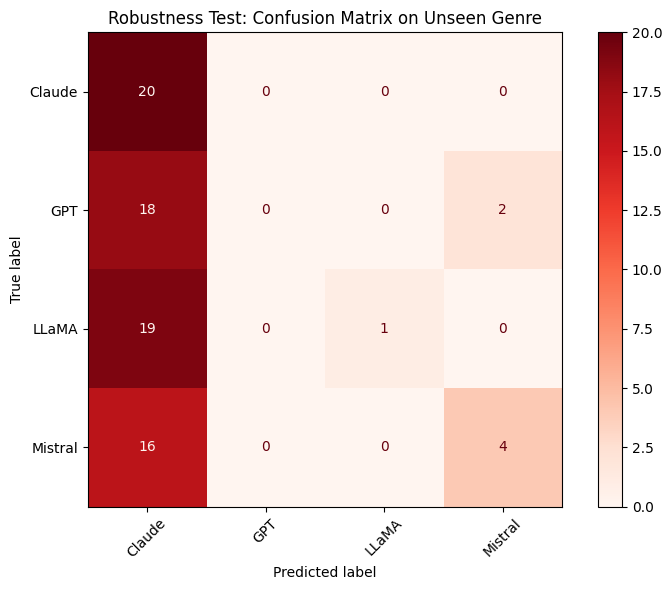

In [22]:
# Test if the model can still identify the LLM on a completely uknown genre
X_robust = df_robust[feature_columns]
y_robust = df_robust['model']

print(f"--- Testing Robustness ---")
print(f"Evaluating how well the classifier identifies models on the unseen '{robustness_genre}' genre:")

# Assigning it to a variable for readability reasons
_ = test_robustness(classifier, X_robust, y_robust)

# **Narration**

In [23]:

exclude_cols = ['doc_id', 'model', 'genre', 'prompt', 'text']
feature_columns = [col for col in df.columns if col not in exclude_cols]

robustness_genre = 'narration'
df_standard = df[df['genre'] != robustness_genre]
df_robust = df[df['genre'] == robustness_genre]

X = df_standard[feature_columns]
y = df_standard['model']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} documents")
print(f"Standard Testing set size: {X_test.shape[0]} documents")
print(f"Robustness set size (Only {robustness_genre}): {df_robust.shape[0]} documents")

Training set size: 192 documents
Standard Testing set size: 48 documents
Robustness set size (Only narration): 80 documents


Evaluating on standard test set...
--- Classification Report ---
              precision    recall  f1-score   support

      Claude       0.92      1.00      0.96        12
         GPT       1.00      1.00      1.00        12
       LLaMA       1.00      1.00      1.00        12
     Mistral       1.00      0.92      0.96        12

    accuracy                           0.98        48
   macro avg       0.98      0.98      0.98        48
weighted avg       0.98      0.98      0.98        48



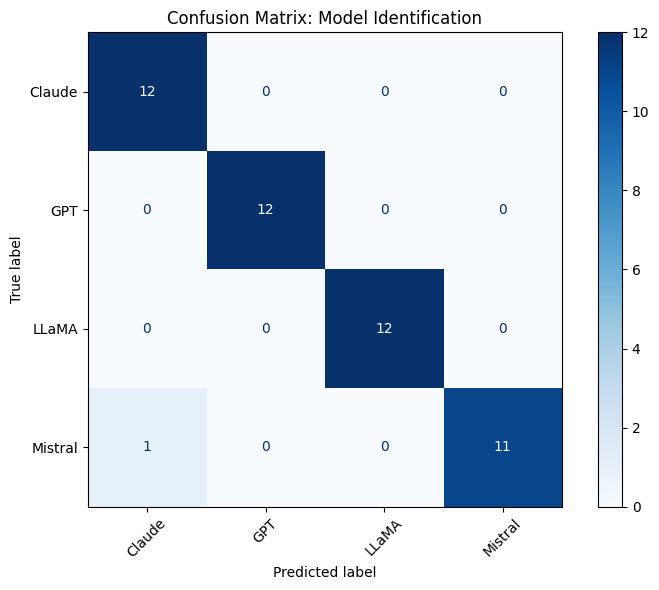

/content/drive/MyDrive/src/analysis/classifier.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


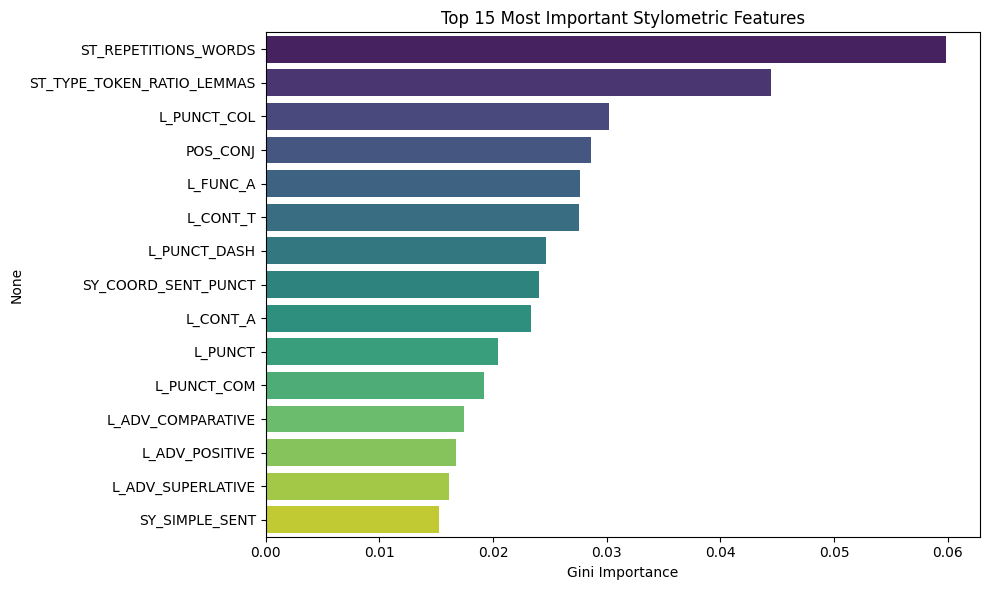

In [24]:

classifier = ModelClassifier(n_estimators=200)
classifier.train(X_train, y_train, feature_columns)

print("Evaluating on standard test set...")
predictions = classifier.evaluate(X_test, y_test)

classifier.plot_feature_importance(top_k=15)

Calculating SHAP values...


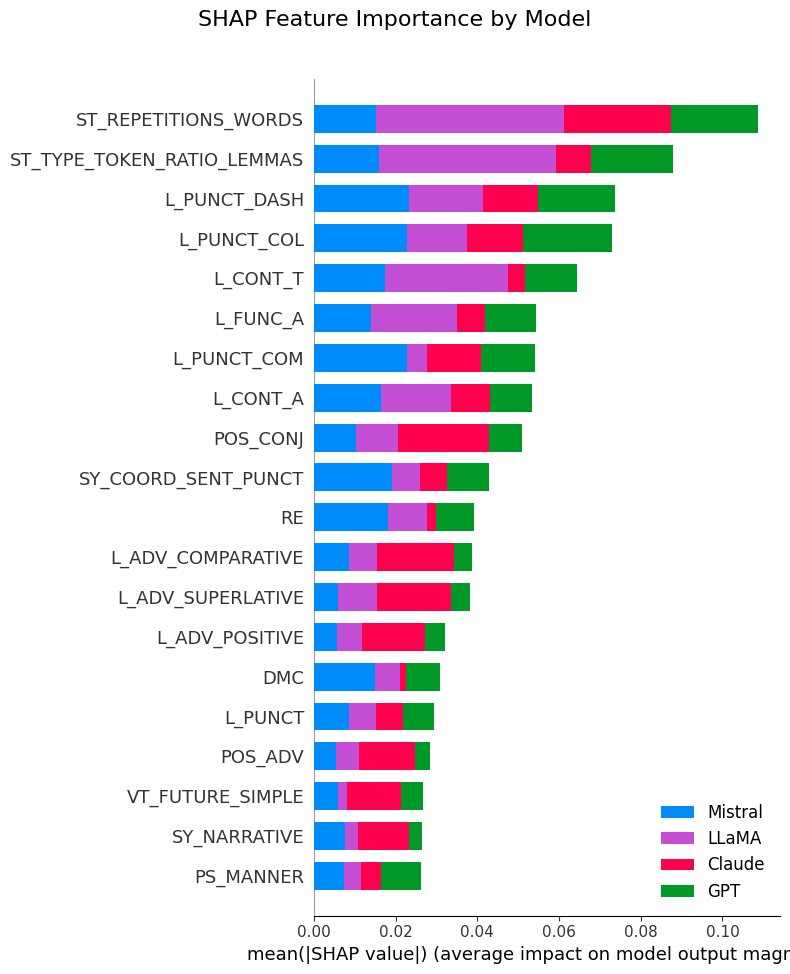

In [25]:
shap_explain(classifier, X, feature_columns)

--- Testing Robustness ---
Evaluating how well the classifier identifies models on the unseen 'narration' genre:
--- Robustness Test: Style-Modified Prompts ---
              precision    recall  f1-score   support

      Claude       0.54      0.75      0.62        20
         GPT       0.53      0.45      0.49        20
       LLaMA       0.82      0.45      0.58        20
     Mistral       0.33      0.40      0.36        20

    accuracy                           0.51        80
   macro avg       0.55      0.51      0.51        80
weighted avg       0.55      0.51      0.51        80



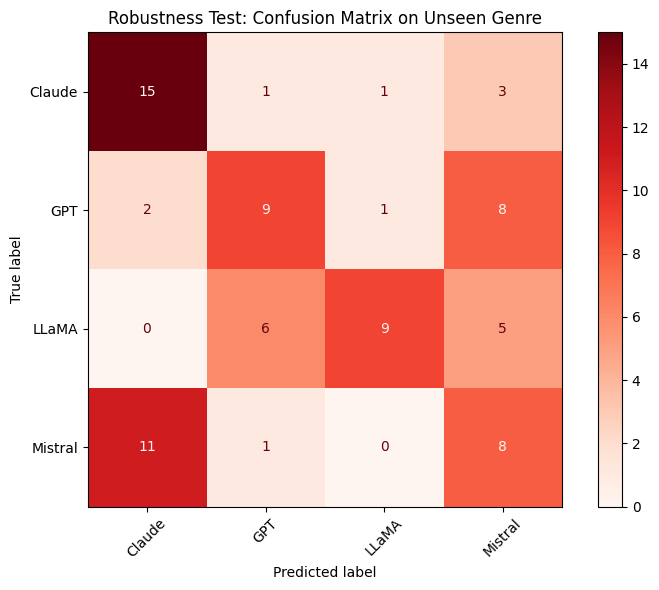

In [26]:

X_robust = df_robust[feature_columns]
y_robust = df_robust['model']

print(f"--- Testing Robustness ---")
print(f"Evaluating how well the classifier identifies models on the unseen '{robustness_genre}' genre:")

_ = test_robustness(classifier, X_robust, y_robust)

# **Argumentation**

In [27]:

exclude_cols = ['doc_id', 'model', 'genre', 'prompt', 'text']
feature_columns = [col for col in df.columns if col not in exclude_cols]

robustness_genre = 'argumentation'

df_standard = df[df['genre'] != robustness_genre]
df_robust = df[df['genre'] == robustness_genre]

X = df_standard[feature_columns]
y = df_standard['model']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} documents")
print(f"Standard Testing set size: {X_test.shape[0]} documents")
print(f"Robustness set size (Only {robustness_genre}): {df_robust.shape[0]} documents")

Training set size: 192 documents
Standard Testing set size: 48 documents
Robustness set size (Only argumentation): 80 documents


Evaluating on standard test set...
--- Classification Report ---
              precision    recall  f1-score   support

      Claude       0.92      1.00      0.96        12
         GPT       1.00      1.00      1.00        12
       LLaMA       1.00      1.00      1.00        12
     Mistral       1.00      0.92      0.96        12

    accuracy                           0.98        48
   macro avg       0.98      0.98      0.98        48
weighted avg       0.98      0.98      0.98        48



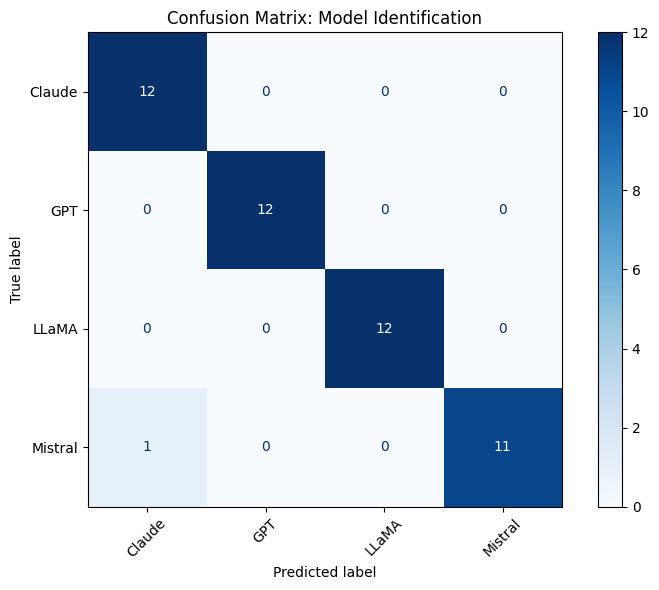

/content/drive/MyDrive/src/analysis/classifier.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


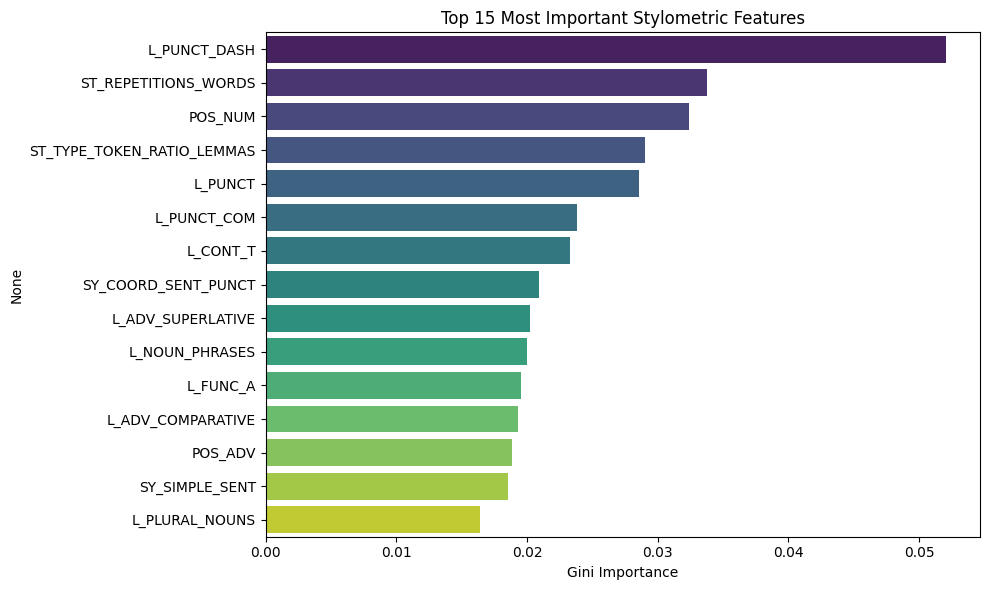

In [28]:

classifier = ModelClassifier(n_estimators=200)
classifier.train(X_train, y_train, feature_columns)


print("Evaluating on standard test set...")
predictions = classifier.evaluate(X_test, y_test)

classifier.plot_feature_importance(top_k=15)

Calculating SHAP values...


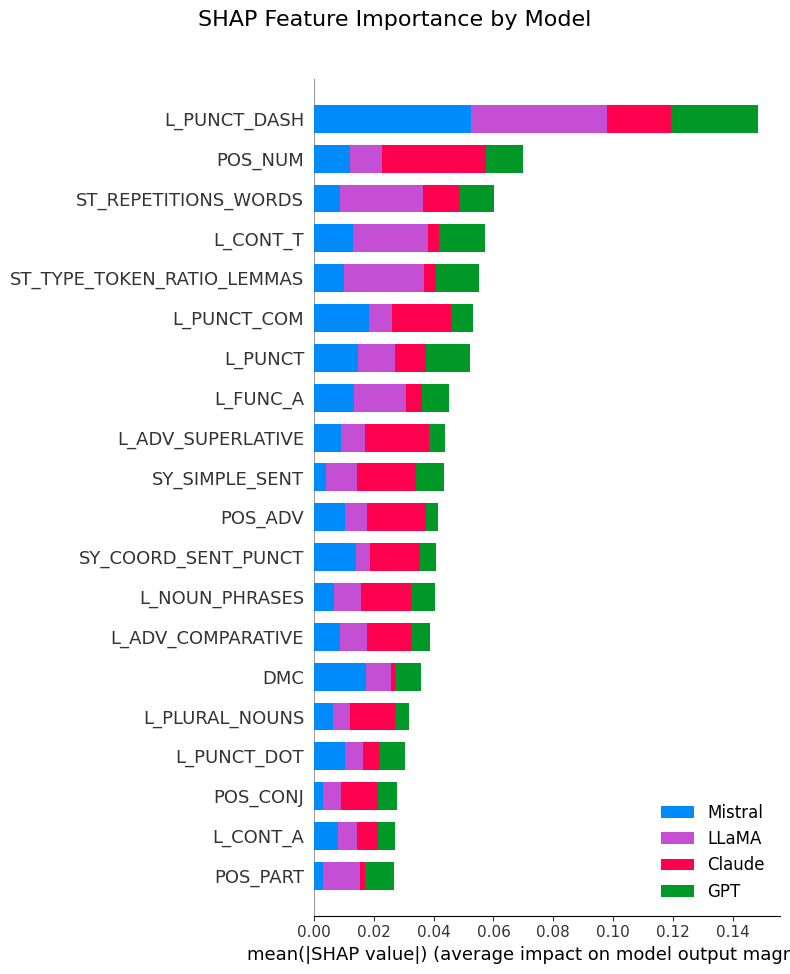

In [29]:
shap_explain(classifier, X, feature_columns)

--- Testing Robustness ---
Evaluating how well the classifier identifies models on the unseen 'argumentation' genre:
--- Robustness Test: Style-Modified Prompts ---
              precision    recall  f1-score   support

      Claude       1.00      0.05      0.10        20
         GPT       0.32      0.35      0.33        20
       LLaMA       0.59      1.00      0.74        20
     Mistral       0.61      0.70      0.65        20

    accuracy                           0.53        80
   macro avg       0.63      0.52      0.46        80
weighted avg       0.63      0.53      0.46        80



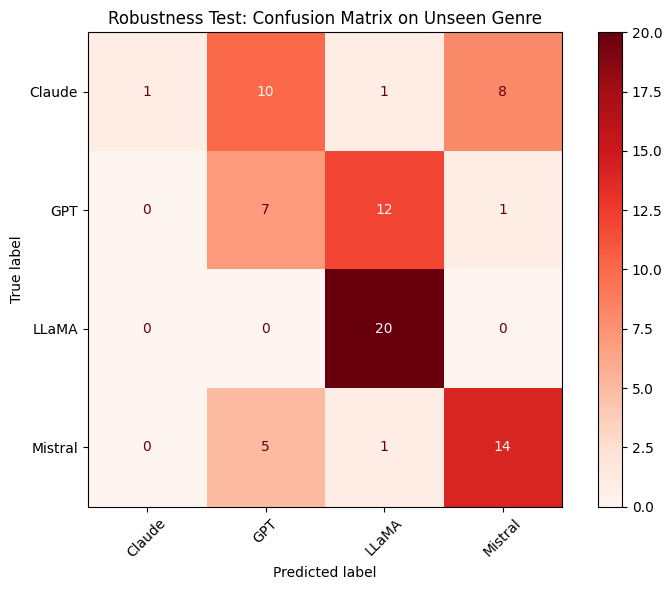

In [30]:

X_robust = df_robust[feature_columns]
y_robust = df_robust['model']

print(f"--- Testing Robustness ---")
print(f"Evaluating how well the classifier identifies models on the unseen '{robustness_genre}' genre:")

_ = test_robustness(classifier, X_robust, y_robust)

# **Description**

In [31]:

exclude_cols = ['doc_id', 'model', 'genre', 'prompt', 'text']
feature_columns = [col for col in df.columns if col not in exclude_cols]

robustness_genre = 'description'

df_standard = df[df['genre'] != robustness_genre]
df_robust = df[df['genre'] == robustness_genre]

X = df_standard[feature_columns]
y = df_standard['model']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} documents")
print(f"Standard Testing set size: {X_test.shape[0]} documents")
print(f"Robustness set size (Only {robustness_genre}): {df_robust.shape[0]} documents")

Training set size: 192 documents
Standard Testing set size: 48 documents
Robustness set size (Only description): 80 documents


Evaluating on standard test set...
--- Classification Report ---
              precision    recall  f1-score   support

      Claude       1.00      1.00      1.00        12
         GPT       1.00      0.83      0.91        12
       LLaMA       0.86      1.00      0.92        12
     Mistral       1.00      1.00      1.00        12

    accuracy                           0.96        48
   macro avg       0.96      0.96      0.96        48
weighted avg       0.96      0.96      0.96        48



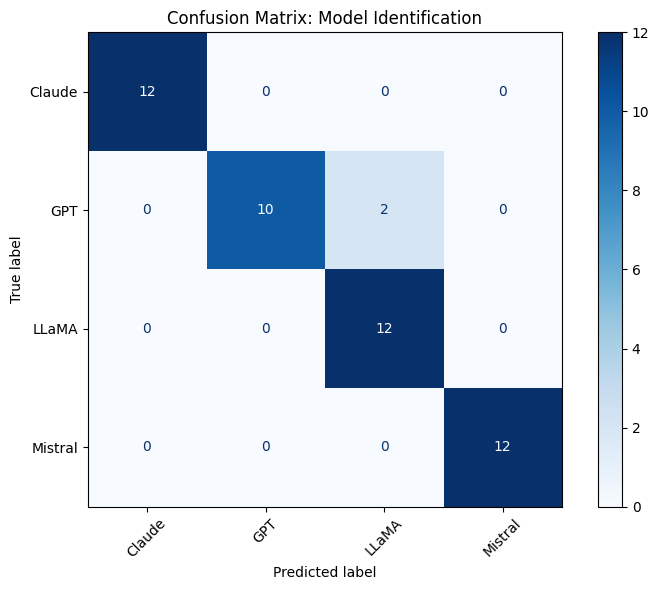

/content/drive/MyDrive/src/analysis/classifier.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette="viridis")


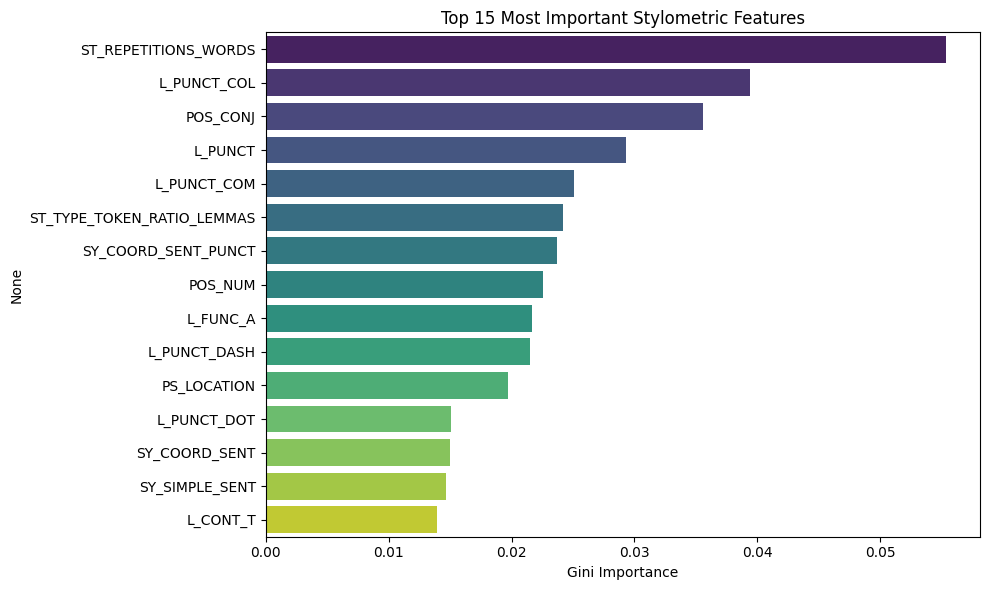

In [32]:

classifier = ModelClassifier(n_estimators=200)
classifier.train(X_train, y_train, feature_columns)

print("Evaluating on standard test set...")
predictions = classifier.evaluate(X_test, y_test)

classifier.plot_feature_importance(top_k=15)

Calculating SHAP values...


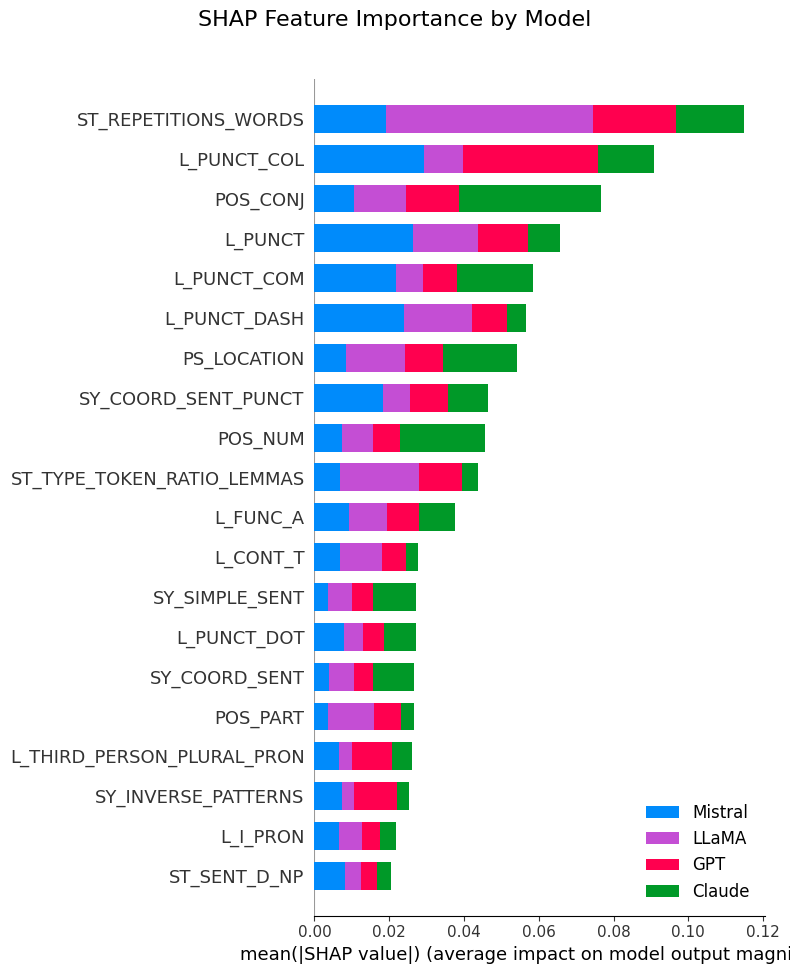

In [33]:
shap_explain(classifier, X, feature_columns)

--- Testing Robustness ---
Evaluating how well the classifier identifies models on the unseen 'description' genre:
--- Robustness Test: Style-Modified Prompts ---
              precision    recall  f1-score   support

      Claude       0.92      0.55      0.69        20
         GPT       0.22      0.20      0.21        20
       LLaMA       0.42      1.00      0.59        20
     Mistral       0.00      0.00      0.00        20

    accuracy                           0.44        80
   macro avg       0.39      0.44      0.37        80
weighted avg       0.39      0.44      0.37        80



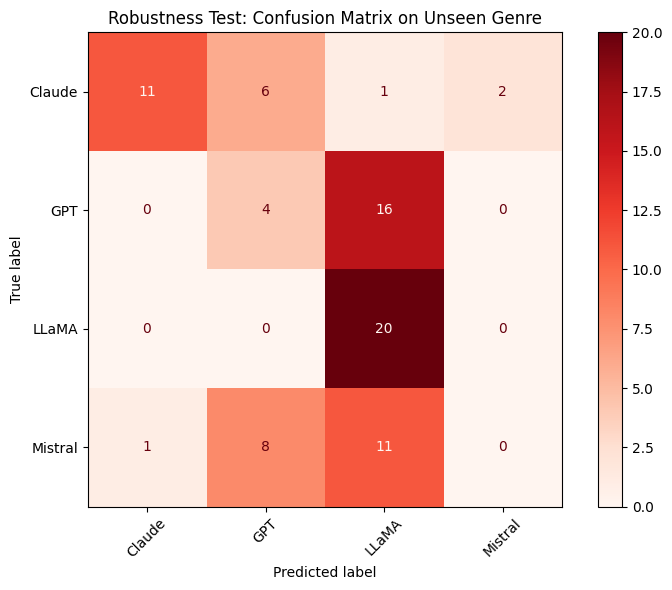

In [34]:

X_robust = df_robust[feature_columns]
y_robust = df_robust['model']

print(f"--- Testing Robustness ---")
print(f"Evaluating how well the classifier identifies models on the unseen '{robustness_genre}' genre:")

_ = test_robustness(classifier, X_robust, y_robust)